In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5

#Quick fudge to make import from ../Scripts work
sys.path.append('../../Scripts')

#Custom imports
# for color map
import seaborn as sns
# for reading datafiles 
import pandas as pd

# import script that has formation channel classification functions:
from PostProcessingScripts import * 

import ClassCOMPAS     as CC ###


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [17]:
path_dir='/Volumes/Andromeda/Data_BlackHole-NeutronStar/' 
DCOtype='BHNS'
nModels=15
BPSnameslist = list(string.ascii_uppercase)[0:nModels]
BPScolors       = sns.color_palette("husl", nModels)

modelDirList = ['fiducial', 'massTransferEfficiencyFixed_0_25', 'massTransferEfficiencyFixed_0_5', 'massTransferEfficiencyFixed_0_75', \
               'unstableCaseBB', 'alpha0_5', 'alpha2_0', 'fiducial', 'rapid', 'maxNSmass2_0', 'maxNSmass3_0', 'noPISN',  'ccSNkick_100km_s', 'ccSNkick_30km_s', 'noBHkick' ]

alphabetDirDict =  {BPSnameslist[i]: modelDirList[i] for i in range(len(BPSnameslist))}
colorDirDict =  {BPSnameslist[i]: BPScolors[i] for i in range(len(BPSnameslist))}

BPSmodelName='F'
path_ = path_dir + alphabetDirDict[BPSmodelName] +'/'
path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'   

fdata = h5.File(path)


print(path)
print(fdata.keys())

/Volumes/Andromeda/Data_BlackHole-NeutronStar/alpha0_5/COMPASCompactOutput_BHNS_F.h5
<KeysViewHDF5 ['RLOF', 'commonEnvelopes', 'doubleCompactObjects', 'formationChannels', 'supernovae', 'systems', 'weights_detected', 'weights_detectedPerRedshift', 'weights_intrinsic', 'weights_intrinsicPerRedshift']>


In [20]:
def makeKDEfigure(axe_ind=None, xparam='M1', BPSmodelNames=['A'], MSSFRmodelNames=MSSFRnameslist, DCOtype='BHNS', xvarrange=None, xlabel='xlabel', ylabel='ylabel', \
                              xlim=[1,30], ylim=[0, None], whichWeight='det', path_dir='/Volumes/Andromeda/Data_BlackHole-NeutronStar/'):
    
    
    """ 
    plot total mass distribution with channels 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    """
    
    # constants
    Zsolar=0.0142
    lw = 2

    MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']
 
    
    if DCOtype=='BHNS':
        DCOname='BHNS'
    elif DCOtype=='BBH':
        DCOname='BHBH'
    elif DCOtype=='BNS':
        DCOname='NSNS'


    
    # path for files 
#     path_dir = '/Volumes/Andromeda/DATA/AllDCO_bugfix/'
    nModels=15
    BPSnameslist = list(string.ascii_uppercase)[0:nModels]
    BPScolors       = sns.color_palette("husl", nModels)
    
    modelDirList = ['fiducial', 'massTransferEfficiencyFixed_0_25', 'massTransferEfficiencyFixed_0_5', 'massTransferEfficiencyFixed_0_75', \
                   'unstableCaseBB', 'alpha0_5', 'alpha2_0', 'fiducial', 'rapid', 'maxNSmass2_0', 'maxNSmass3_0', 'noPISN',  'ccSNkick_100km_s', 'ccSNkick_30km_s', 'noBHkick' ]

    alphabetDirDict =  {BPSnameslist[i]: modelDirList[i] for i in range(len(BPSnameslist))}
    colorDirDict =  {BPSnameslist[i]: BPScolors[i] for i in range(len(BPSnameslist))}
	#####


        


    for ind_m, BPSmodelName in enumerate(BPSmodelNames):
        axe = ax[axe_ind,ind_m]
        
        if ind_m%15==0:
            print('now at m=', BPSmodelName)

        


        # data for KDE / PDF:
        path_ = path_dir + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'   

        fdata = h5.File(path)

            
            
        if xparam in ['MBH', 'MNS', 'q', 'Mchirp', 'Mtot']:

            # obtain BH and NS masses
            xvar1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
            xvar2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
            M1, M2 = obtainM1BHandM2BHassymetric(m1=xvar1, m2=xvar2) # M1 will be the most massive, M2 the least massive compact object. 
            if xparam =='Mtot':
                xvar=M1+M2
            elif xparam=='MBH':
                xvar = M1
            elif xparam=='MNS':
                xvar = M2 
            elif xparam =='q':
                xvar = M1/M2
            elif xparam=='Mchirp':
                xvar = chirpmass(M1,M2)

            del M1
            del M2
            del xvar1
            del xvar2

        elif xparam=='logZ':
            ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
            xvar = np.log10((ZZ))
            
        elif xparam=='Z':
            ZZ = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
            xvar = ((ZZ))

            
        elif xparam=='tc':
            tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
            xvar = tc / 1000. # in Gyr. 

        elif xparam=='tdelay':
            tc = fdata['doubleCompactObjects']['tc'][...].squeeze()
            tform = fdata['doubleCompactObjects']['tform'][...].squeeze()
            xvar = (tc/1000) + (tform / 1000) # in Gyr 
            del tc 
            del tform
        else:
            print('KeyError')
            
        label = None


        BPScolor = colorDirDict[BPSmodelName]
            
            
        ymax=0
        ii=0
        for ind_mssfr, mssfr in enumerate(MSSFRmodelNames):
            # read in MSSFR weights: 
            if whichWeight=='det':
                # get detected weights
                fparam_key = 'weights_detected'
            elif whichWeight=='z0':
                # get intrinsic weights
                fparam_key = 'weights_intrinsic'

            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()

            # highlight the SFRD if they are one of the following 3
            if mssfr in ['000', '231', '312']:
                MSSFRalpha=1
                if mssfr=='000':
                    MSSFRzorder = 57
                    MSSFRlinestyle = MSSFRlinestyles[0]                    
                elif mssfr=='231':
                    MSSFRzorder=55
                    MSSFRlinestyle = MSSFRlinestyles[1]
                elif mssfr=='312':
                    MSSFRzorder=54
                    MSSFRlinestyle = MSSFRlinestyles[2]
            else:
                MSSFRalpha=0.5
                MSSFRlinestyle = '-'
                MSSFRzorder=51   
                
            BPScolor = colorDirDict[BPSmodelName]



    
    
            # make the KDE, by calculating KDE values for the following x points 
            xx_boot = np.linspace(xvarrange[0],xvarrange[1],100)

            # set bandwidth (dimensionless) based on the no of samples in the data. 
            lenXvar = len(xvar)
            if lenXvar<=100000:
                bw=0.1
            elif lenXvar>2*10**6:
                bw = 0.03
            elif (lenXvar<=2*10**6) & (lenXvar>10**6):
                bw = 0.04
            elif (lenXvar<=10**6) & (lenXvar>5*10**5):
                bw = 0.05 
            elif (lenXvar<=5*10**5) & (lenXvar>10**5):
                bw = 0.06
            else:
                print('error!! bw not defined')
            
            # for metallicity we want a seperate, larger KDE bandwidth, since here the resolution is limited by our no of Zi grid points
            if xparam=='logZ':
                bw = 0.1
            if (mssfr=='000')&(axe_ind==0):
                print('Model ', BPSmodelName, 'with %s DCOs is given a kde bandwidth of '%len(xvar),  'bw=', bw)
                
            KDE = gaussian_kde(xvar, weights=w, bw_method=bw)
            yy_boot = KDE(xx_boot)


            axe.plot(yy_boot,xx_boot,  alpha=MSSFRalpha, color=BPScolor, zorder=MSSFRzorder, label=None,\
                     linewidth=lw, linestyle=MSSFRlinestyle ) 

            ymax = np.max(np.asarray([ymax,np.max(yy_boot)]))
            ylim[1]=ymax*1.05    

       
                
                
        fdata.close()

    
        del xvar
        del w

        ax2y = axe.twiny()
        ax2y.set_xlim(ylim[0], ylim[1])
        if xparam=='MBH':
            center_x = (ylim[0] + (ylim[1]-ylim[0])/2)
            ax2y.set_xticks([center_x])
            ax2y.set_xticklabels([alphabetPhysicalNameDictWithEnter[BPSmodelName]], fontsize=fs-7, rotation=30) #rotation=55,
        else: 
            ax2y.set_xticks([])
            for tick in ax2y.yaxis.get_major_ticks():
                tick.label.set_fontsize(0.1) 
                
                
                
        ###########
        fsyticks = 15
        if xlim:
            axe.set_ylim(xlim[0], xlim[1])
        if ylim:
            axe.set_xlim(ylim[0], ylim[1])

        if BPSmodelName =='A':
            axe.set_ylabel(ylabel, fontsize=fs)
            axe.tick_params(labelsize=fsyticks)
            
        else:
            axe.set_yticklabels( () )
            axe.set_yticks([])

        axe.set_xticks([])
        axe.set_xticklabels( () )



        ########################
        # SECOND Y-AXIS 
        ax2x = axe.twinx()
        if BPSmodelName =='O':
            ax2x.set_ylim(xlim[0], xlim[1])
            ax2x.set_ylabel(ylabel, fontsize=fs)
            ax2x.tick_params(labelsize=fsyticks)
        else:
            ax2x.set_yticklabels( () )
            ax2x.set_yticks([])




    #################
    

        if xparam=='logZ':
            center_x = (ylim[0] + (ylim[1]-ylim[0])/2)

            axe.set_xticks([center_x])
            axe.set_xticklabels([BPSmodelName],  fontsize=fs) #rotation=55,


    
    return 0,0 






now at m= A
Model  A with 1525553 DCOs is given a kde bandwidth of  bw= 0.04
Model  B with 738537 DCOs is given a kde bandwidth of  bw= 0.05
Model  C with 148043 DCOs is given a kde bandwidth of  bw= 0.06
Model  D with 118921 DCOs is given a kde bandwidth of  bw= 0.06
Model  E with 458667 DCOs is given a kde bandwidth of  bw= 0.06
Model  F with 915179 DCOs is given a kde bandwidth of  bw= 0.05
Model  G with 833433 DCOs is given a kde bandwidth of  bw= 0.05
Model  H with 1535042 DCOs is given a kde bandwidth of  bw= 0.04
Model  I with 2766298 DCOs is given a kde bandwidth of  bw= 0.03
Model  J with 959796 DCOs is given a kde bandwidth of  bw= 0.05
Model  K with 1990330 DCOs is given a kde bandwidth of  bw= 0.04
Model  L with 1524497 DCOs is given a kde bandwidth of  bw= 0.04
Model  M with 3049458 DCOs is given a kde bandwidth of  bw= 0.03
Model  N with 4198238 DCOs is given a kde bandwidth of  bw= 0.03
Model  O with 5068628 DCOs is given a kde bandwidth of  bw= 0.03
now at m= A
now at m

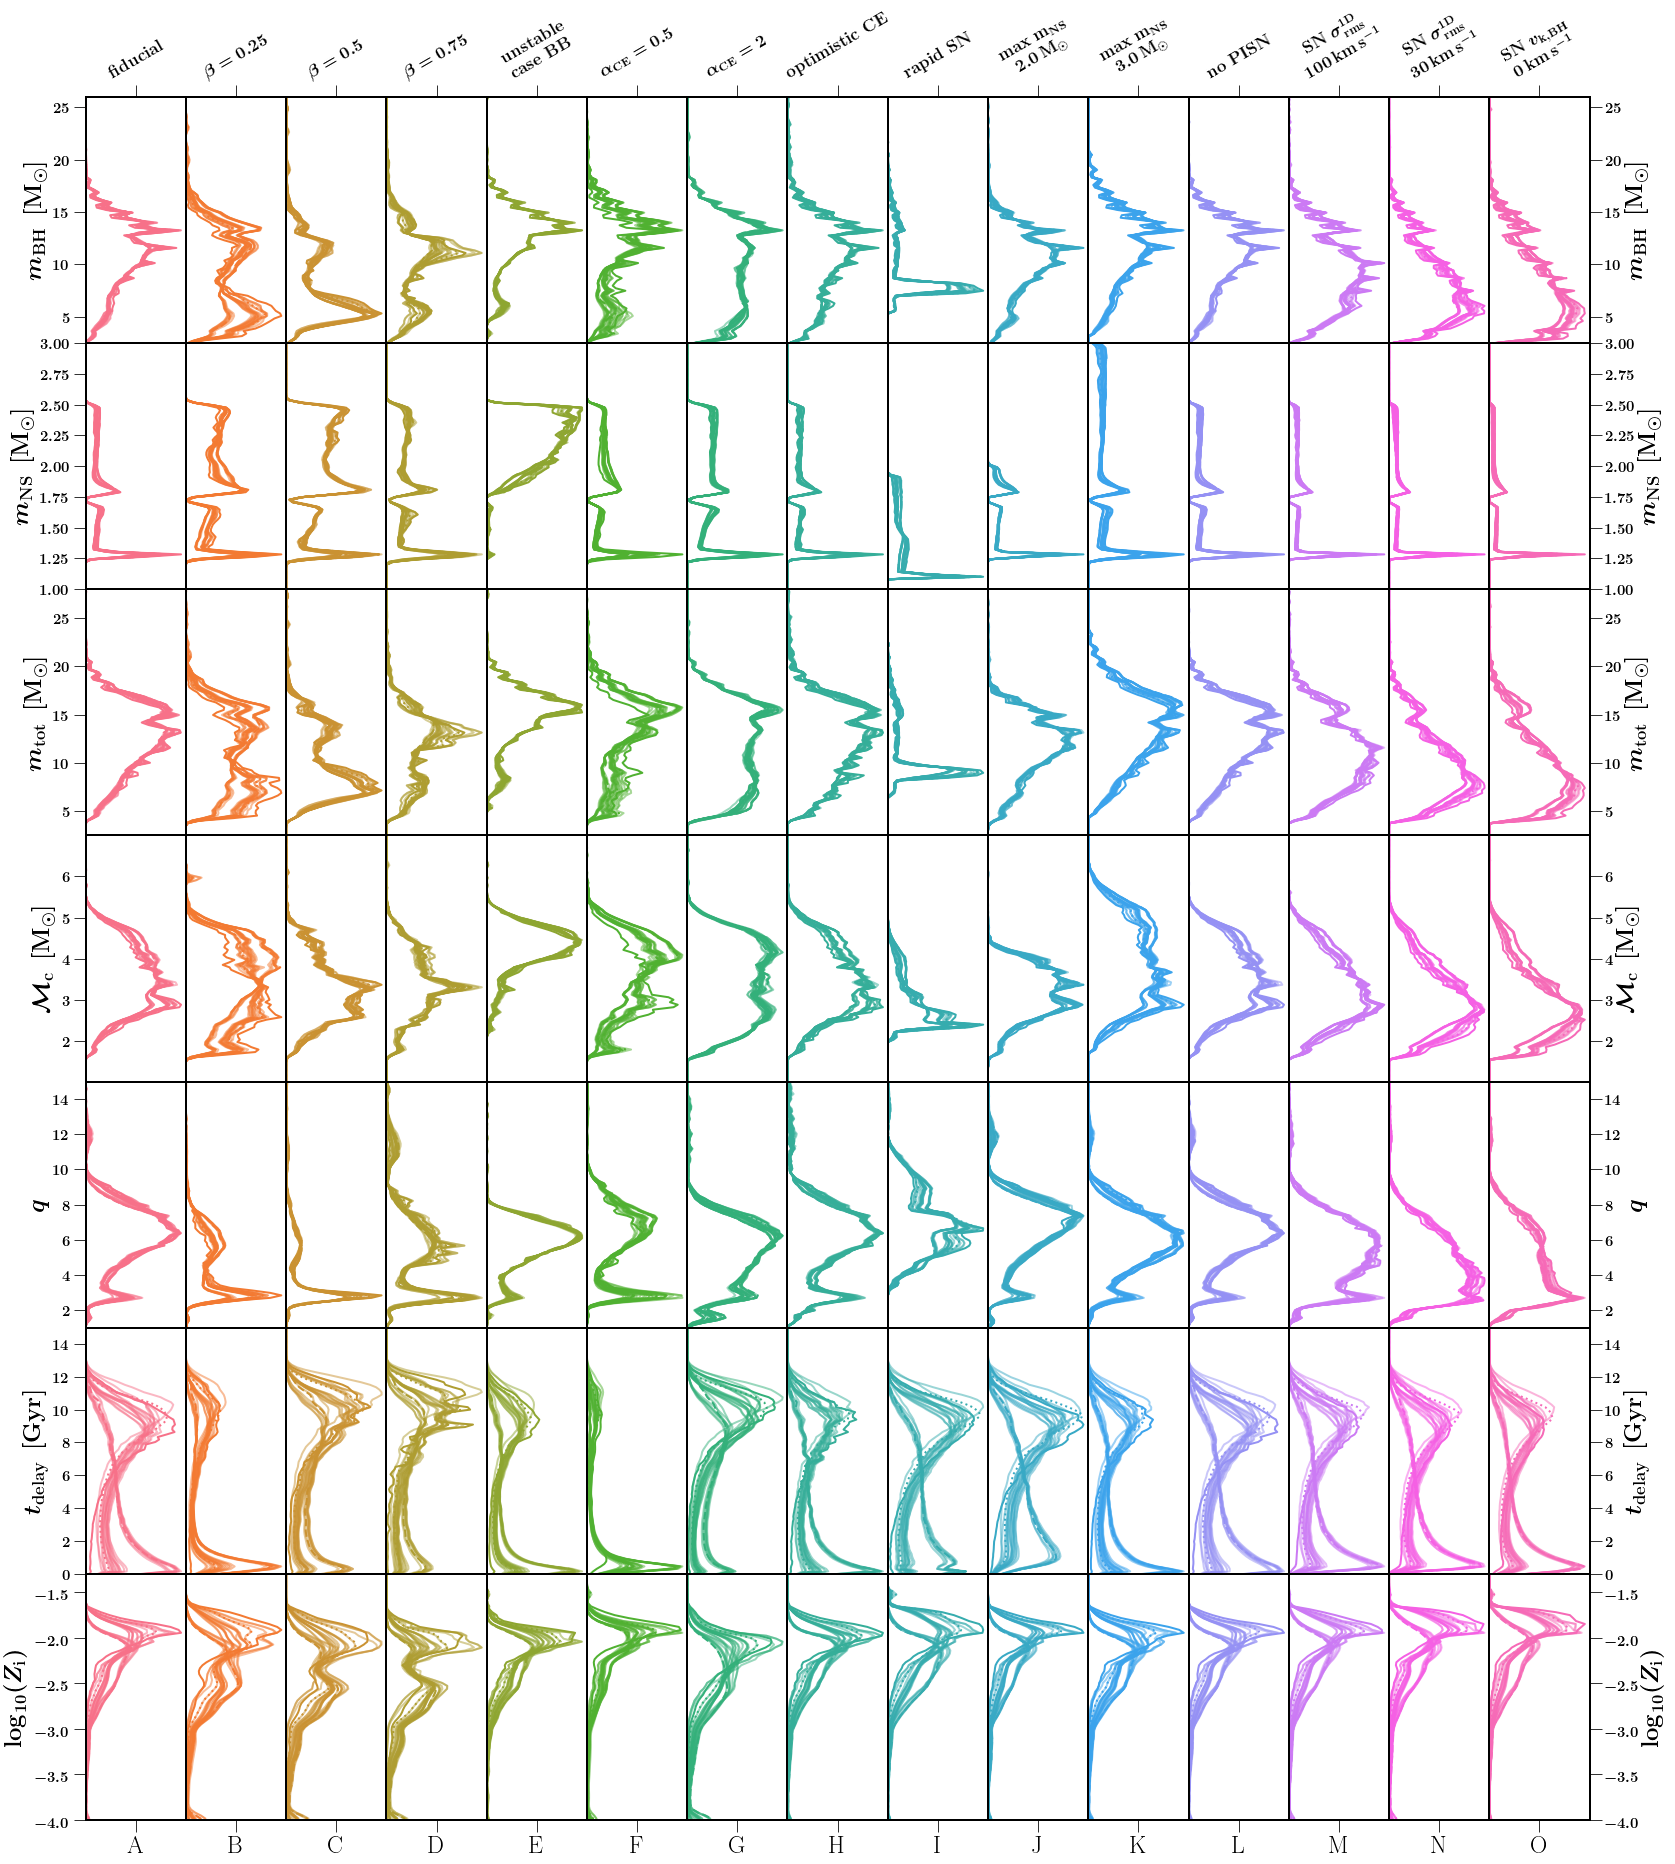

In [21]:

# add location of the COMPAS hdf5 files:
path_dir = '/Volumes/Andromeda/Data_BlackHole-NeutronStar/'






ncols, nrows= 15,7
f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(23,26), 
              gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})


# for ind_bps, BPS in enumerate(['A']):#, 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']):
# Zsolar=0.0142
nModels=15
BPSnameslist = list(string.ascii_uppercase)[0:nModels]
MSSFRalphas = [1., 0.5, 0.5, 0.5]
MSSFRlinestyles = ['-'                        , '--'                         , ':'                           , '-.']


MSSFRnameslist = ['000', '111', '211', '311', '112', '212', '312', '113', '213', '313', '121', '221', '321', '122', '222', '322', '123', '223', '323', '131', '231', '331', '132', '232', '332', '133', '233', '333']
TYPE = 'BHNS'
BPSnameslist = list(string.ascii_uppercase)[0:nModels]
BPScolors       = sns.color_palette("husl", len(BPSnameslist))
colorDirDict =  {BPSnameslist[i]: BPScolors[i] for i in range(len(BPSnameslist))}


handles, labels = None, None
# BPSlist = [BPS]
whichWeight='det'

nameX = r'  a'
nameY = r' $m_{\rm{BH}} $ $ \,  [\rm{M}_{\odot}]$'
xparam='MBH'
_,_=makeKDEfigure(axe_ind=0,xparam=xparam,  BPSmodelNames=BPSnameslist,\
        MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[2.2,26], xlabel=nameX, ylabel=nameY, \
                                          xlim=[2.5,25.999], ylim=[0.0,None], whichWeight=whichWeight,  path_dir=path_dir)#, whichBPScolor=whichBPScolor) 

nameX = r'$-  $'
nameY = r' $m_{\rm{NS}} $ $ \,  [\rm{M}_{\odot}]$'
xparam='MNS'
_,_=makeKDEfigure(axe_ind=1,xparam=xparam,  BPSmodelNames=BPSnameslist,\
        MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[1,3], xlabel=nameX, ylabel=nameY, \
                              xlim=[1,3.], ylim=[0.,None], whichWeight=whichWeight,  path_dir=path_dir)#, whichBPScolor=whichBPScolor)     

#     nameX = r'${\rm{d}}P / {\rm{d}}  m_{\rm{tot}}  $'
nameY = r' $m_{\rm{tot}}$ $ \,  [\rm{M}_{\odot}]$'
xparam='Mtot'
_,_=makeKDEfigure(axe_ind=2,xparam=xparam,  BPSmodelNames=BPSnameslist,\
        MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[2.2,28], xlabel=nameX, ylabel=nameY, \
                              xlim=[2.501,27.9999], ylim=[0.0,None], whichWeight=whichWeight,  path_dir=path_dir)#, whichBPScolor=whichBPScolor) 


#     nameX = r'${\rm{d}}P / {\rm{d}} {M}_{\rm{c}}  $'
nameY = r' $\mathcal{M}_{\rm{c}}$ $ \,  [\rm{M}_{\odot}]$'
xparam='Mchirp'
_,_=makeKDEfigure(axe_ind=3, xparam=xparam,  BPSmodelNames=BPSnameslist,\
        MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[1, 7], xlabel=nameX, ylabel=nameY, \
                              xlim=[1.01,6.999], ylim=[0.0,None],  whichWeight=whichWeight,  path_dir=path_dir) 


#     nameX = r'${\rm{d}}P / {\rm{d}} q  $'
nameY = r' $q$ $ \, $'
xparam='q'
_,_=makeKDEfigure(axe_ind=4, xparam=xparam, BPSmodelNames=BPSnameslist,\
        MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[1,15], xlabel=nameX, ylabel=nameY, \
                              xlim=[1.00,14.999], ylim=[0,None], whichWeight=whichWeight,  path_dir=path_dir)     


nameY = r' $t_{\rm{delay}}$ $ \, [{\rm{Gyr}}]$'
xparam='tdelay'
_,_=makeKDEfigure(axe_ind=5, xparam=xparam, BPSmodelNames=BPSnameslist,\
        MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[0,15], xlabel=nameX, ylabel=nameY, \
                              xlim=[0,14.99], ylim=[0,None], whichWeight=whichWeight,  path_dir=path_dir)      





nameY = r' $\log_{10}(Z_{\rm{i}})$ $ \, $'
xparam='logZ'
xmin = np.log10(0.0001)
xmax = np.log10(0.0499)
_,_=makeKDEfigure(axe_ind=6,xparam=xparam,  BPSmodelNames=BPSnameslist,\
        MSSFRmodelNames=MSSFRnameslist, DCOtype=TYPE, xvarrange=[xmin-0.5,xmax], xlabel=nameX, ylabel=nameY, \
                              xlim=[xmin,xmax], ylim=[0.001,None],  whichWeight=whichWeight,  path_dir=path_dir) 


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('./megaKDEplot2_' + whichWeight   + TYPE+ '.png', transparent=False, bbox_inches='tight')
plt.show()
plt.close()








